In [1]:
import os,sys
import math

import numpy as np
import scipy as sp
import pandas as pd
import matplotlib as mlt
import matplotlib.pyplot as plt
from IPython.display import HTML
from matplotlib import animation
import seaborn as sns
from sklearn.model_selection import train_test_split,cross_val_score, KFold, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_regression, chi2, f_classif, VarianceThreshold


from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
sys.path.append("../src/all")  # adjust path as needed
from read_Parkinsonpredict import ReadData, LoadData
from ml_models import MlModels

##### Selecting 100 high NHY patients and 100 0 NHY patients

In [2]:
input_path = '/Users/pushpita/Documents/Erdos_bootcamp/our_project/Data/fomatted_data/Updated/'
data_matrix = pd.read_csv(input_path + 'gene_matrix1.csv')

In [3]:
X_data = data_matrix.drop(columns=["PATNO", "EVENT_ID", "NHY"])
Y_data = data_matrix["NHY"]
sparsity = (X_data == 0).mean().mean()
print(f"Sparsity: {sparsity:.2%}")

Y_data_grouped = Y_data.copy()
Y_data_grouped[Y_data_grouped == 0] = 0
Y_data_grouped[(Y_data_grouped == 1) | (Y_data_grouped == 2)] = 1
Y_data_grouped[Y_data_grouped > 2] = 2

Sparsity: 33.94%


In [4]:
# X_data is (n_samples, n_genes), entries are TPM counts
threshold_count = 5
threshold_fraction = 0.10

gene_mask = (X_data > threshold_count).sum(axis=0) >= (threshold_fraction * X_data.shape[0])
X_filtered = X_data.loc[:, gene_mask]

In [5]:
# Step 2: Remove low-variance genes
var_thresh = VarianceThreshold(threshold=1e-5)
X_nonconstant = pd.DataFrame(
    var_thresh.fit_transform(X_filtered),
    columns=X_filtered.columns[var_thresh.get_support()],
    index=X_filtered.index
)

In [6]:
# Step 3: Scale the data
scaler_cls = StandardScaler()
X_scaled = pd.DataFrame(
    scaler_cls.fit_transform(X_nonconstant),
    columns=X_nonconstant.columns,
    index=X_nonconstant.index
)

In [11]:
# selector = SelectKBest(score_func=f_classif, k=100)
selector = SelectKBest(score_func=f_classif, k=100)
X_selected = selector.fit_transform(X_scaled, Y_data_grouped)
# selector = SelectFpr(score_func=f_classif, alpha=0.05)  # or alpha=0.01
# Step 5: Get gene names
selected_mask = selector.get_support()
selected_genes = X_scaled.columns[selected_mask]

print("Top selected genes:")
print(selected_genes.tolist())


Top selected genes:
['ENSG00000102245', 'ENSG00000187116', 'ENSG00000273837', 'ENSG00000105501', 'ENSG00000076662', 'ENSG00000167658', 'ENSG00000266405', 'ENSG00000123700', 'ENSG00000213246', 'ENSG00000160179', 'ENSG00000167207', 'ENSG00000198736', 'ENSG00000258819', 'ENSG00000211821', 'ENSG00000152484', 'ENSG00000128383', 'ENSG00000166130', 'ENSG00000257878', 'ENSG00000217555', 'ENSG00000184613', 'ENSG00000276900', 'ENSG00000059804', 'ENSG00000166435', 'ENSG00000284948', 'ENSG00000232021', 'ENSG00000138678', 'ENSG00000167434', 'ENSG00000163993', 'ENSG00000174007', 'ENSG00000281162', 'ENSG00000240972', 'ENSG00000151651', 'ENSG00000246263', 'ENSG00000228242', 'ENSG00000073737', 'ENSG00000172809', 'ENSG00000165929', 'ENSG00000253210', 'ENSG00000249667', 'ENSG00000204308', 'ENSG00000197956', 'ENSG00000175538', 'ENSG00000238243', 'ENSG00000169507', 'ENSG00000209042', 'ENSG00000145491', 'ENSG00000115607', 'ENSG00000117174', 'ENSG00000258082', 'ENSG00000237803', 'ENSG00000270276', 'ENSG00000

In [12]:
f_vals, p_vals = f_classif(X_scaled[selected_genes.tolist()], Y_data)
f_scores_df = pd.DataFrame({
    "gene": selected_genes.tolist(),
    "F_score": f_vals,
    "p_value": p_vals
})
f_scores_df_sorted = f_scores_df.sort_values(by="F_score", ascending=False)
print(f_scores_df_sorted)

               gene    F_score       p_value
10  ENSG00000167207  10.179340  1.519471e-09
73  ENSG00000213347  10.057250  2.000429e-09
34  ENSG00000073737  10.015264  2.198823e-09
33  ENSG00000228242   9.866806  3.071695e-09
13  ENSG00000211821   9.630930  5.223790e-09
..              ...        ...           ...
22  ENSG00000166435   4.257571  7.720930e-04
89  ENSG00000211751   4.223462  8.304621e-04
53  ENSG00000250220   4.119025  1.037630e-03
79  ENSG00000233844   3.914387  1.602162e-03
54  ENSG00000278879   3.867303  1.769879e-03

[100 rows x 3 columns]


In [13]:
data_all_vis = pd.concat([X_scaled[selected_genes.tolist()], Y_data.to_frame(name='NHY')],axis=1)

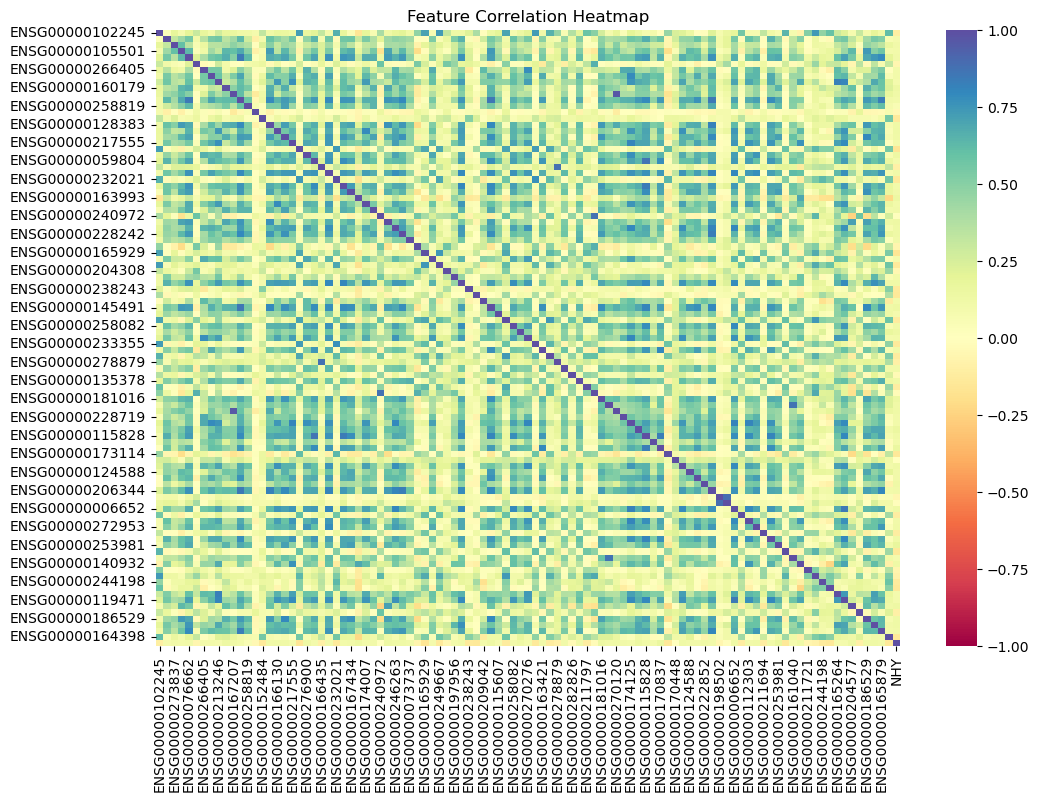

In [14]:
plt.figure(figsize=(12, 8))
sns.heatmap(data_all_vis.corr(numeric_only=True), cmap='Spectral', annot=False, vmin=-1, vmax=1)
plt.title("Feature Correlation Heatmap")
plt.show()

In [12]:
corr_matrix = X_scaled[selected_genes.tolist()].corr().abs()
upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

threshold = 0.95
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > threshold)]

# Drop those columns
X_deduplicated = X_scaled[selected_genes.tolist()].drop(columns=to_drop)

print(f"Removed {len(to_drop)} highly correlated genes.")

Removed 0 highly correlated genes.


In [13]:
print(selected_genes.tolist())
path = '/Users/pushpita/Documents/Erdos_bootcamp/our_project/Data/'
output_datapath = path + 'fomatted_data/Updated/with_clinical_data'

output_path_geneID = os.path.join(output_datapath, "geneID_feature_selection_50.csv")
f_scores_df_sorted.to_csv(output_path_geneID, index=False)

['ENSG00000102145', 'ENSG00000184792', 'ENSG00000244482', 'ENSG00000105281', 'ENSG00000104892', 'ENSG00000090013', 'ENSG00000158578', 'ENSG00000105610', 'ENSG00000167815', 'ENSG00000095932', 'ENSG00000118046', 'ENSG00000099804', 'ENSG00000066926', 'ENSG00000011028', 'ENSG00000172057', 'ENSG00000100225', 'ENSG00000108405', 'ENSG00000169877', 'ENSG00000067836', 'ENSG00000180185', 'ENSG00000063854', 'ENSG00000156381', 'ENSG00000182512', 'ENSG00000119636', 'ENSG00000100568', 'ENSG00000129472', 'ENSG00000198805', 'ENSG00000102760', 'ENSG00000152484', 'ENSG00000173598', 'ENSG00000111726', 'ENSG00000204323', 'ENSG00000149212', 'ENSG00000263465', 'ENSG00000166435', 'ENSG00000110046', 'ENSG00000052802', 'ENSG00000189060', 'ENSG00000232021', 'ENSG00000163993', 'ENSG00000145335', 'ENSG00000113811', 'ENSG00000214706', 'ENSG00000181788', 'ENSG00000168785', 'ENSG00000231621', 'ENSG00000165929', 'ENSG00000167705', 'ENSG00000249667', 'ENSG00000204613', 'ENSG00000238243', 'ENSG00000132819', 'ENSG000001

### Selecting the clinical data

/var/folders/0v/kl9fb13d2v51vwxc37zr5__00000gn/T/ipykernel_14619/1237848357.py:2: DtypeWarning: Columns (15,19) have mixed types. Specify dtype option on import or set low_memory=False.
  df1 = pd.read_csv(path1+'/MDS-UPDRS_Part_III_03Jun2025.csv')
/var/folders/0v/kl9fb13d2v51vwxc37zr5__00000gn/T/ipykernel_14619/1237848357.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_common, x='GENDER', palette='inferno', edgecolor='black')


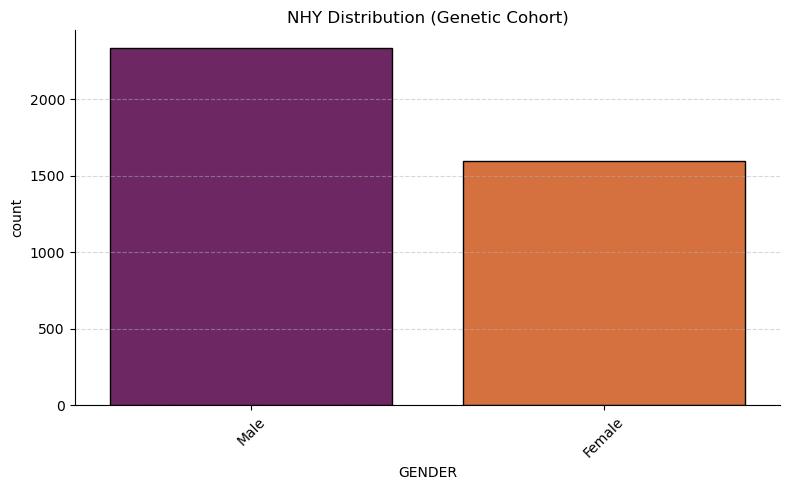

In [14]:
path1 = '/Users/pushpita/Documents/Erdos_bootcamp/our_project/Data/Diagnosis_History_UPDRS_HYS/'
df1 = pd.read_csv(path1+'/MDS-UPDRS_Part_III_03Jun2025.csv')
# Load your metadata CSV
path2 = '/Users/pushpita/Documents/Erdos_bootcamp/our_project/Data/Gene_expression'
df2 = pd.read_csv(path2+'/metaDataIR3.csv')

df_bl = df2[(df2['CLINICAL_EVENT'] == 'BL') & (df2['DIAGNOSIS'] == 'Genetic Cohort') | 
            (df2['CLINICAL_EVENT'] == 'BL') & (df2['DIAGNOSIS'] == 'PD') | 
            (df2['CLINICAL_EVENT'] == 'BL') & (df2['DIAGNOSIS'] == 'Control') |
            (df2['CLINICAL_EVENT'] == 'BL') & (df2['DIAGNOSIS'] == 'Prodromal')]
patno_bl = set(df_bl['PATNO'])
patno_other = set(df1['PATNO'])

common_patnos = patno_bl.intersection(patno_other)

df_common = df2[df2['PATNO'].isin(common_patnos)]
# df_unique = df_common.sort_values('ORIG_ENTRY').drop_duplicates(subset='PATNO', keep='last')

# Plot histogram
plt.figure(figsize=(8, 5))
sns.countplot(data=df_common, x='GENDER', palette='inferno', edgecolor='black')
plt.title('NHY Distribution (Genetic Cohort)')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.5)
sns.despine()
plt.tight_layout()
plt.show()

##### Write the final .csv file

In [15]:
#instiantiate the reading class
path = '/Users/pushpita/Documents/Erdos_bootcamp/our_project/Data/'

input_path = path
output_path = path + 'fomatted_data/Updated/gene_datas_'
data = ReadData(data_path=input_path, output_path=output_path, gene_list=selected_genes.to_list(), 
                write_csv=1, phaseIandII=1, genetic_cohort=1,clinical_data=1)

genedata_all,unmatchedkeys = data.gene_expression(match_event=False)

/Users/pushpita/Documents/Erdos_bootcamp/our_project/code_repo/notebooks/../src/all/read_Parkinsonpredict.py:87: DtypeWarning: Columns (15,19) have mixed types. Specify dtype option on import or set low_memory=False.
  HYS_data = pd.read_csv(HYS_data_path+"MDS-UPDRS_Part_III_03Jun2025.csv")
/Users/pushpita/Documents/Erdos_bootcamp/our_project/code_repo/notebooks/../src/all/read_Parkinsonpredict.py:222: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  gene_counts_df = pd.concat([gene_counts_df, pd.DataFrame([my_row], columns=gene_counts_df.columns)], ignore_index=True)


4756


/Users/pushpita/Documents/Erdos_bootcamp/our_project/code_repo/notebooks/../src/all/read_Parkinsonpredict.py:222: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  gene_counts_df = pd.concat([gene_counts_df, pd.DataFrame([my_row], columns=gene_counts_df.columns)], ignore_index=True)
/Users/pushpita/Documents/Erdos_bootcamp/our_project/code_repo/notebooks/../src/all/read_Parkinsonpredict.py:222: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  gene_counts_df = pd.concat([gene_counts_df, pd.DataFrame([my

Total matched gene files with valid PATNO/EVENT_ID pairs: 3899
